In [2]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  train_test_split
import matplotlib.pyplot as plt


# 0. 判断GPU是否可用

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. 数据预处理

In [4]:
dataPath = "./boston.csv"
df = pd.read_csv(dataPath)

In [5]:
df.shape

(506, 13)

In [6]:
x_data = df.iloc[:, :12].values
y_data = df.MEDV.values
print(x_data.shape)
print(y_data.shape)

(506, 12)
(506,)


In [7]:
# 数据标准化
scaler = StandardScaler()
scaler.fit(x_data)
x_data = scaler.transform(x_data)

In [8]:
# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=56)

In [9]:
# 转换为张量
train_xt = torch.from_numpy(X_train.astype(np.float32))
train_yt = torch.from_numpy(y_train.astype(np.float32))
test_xt = torch.from_numpy(X_test.astype(np.float32))
test_yt = torch.from_numpy(y_test.astype(np.float32))

In [10]:
# 数据集加载器
train_data = Data.TensorDataset(train_xt, train_yt)

In [11]:
train_loader = Data.DataLoader(dataset=train_data,
                               batch_size=32,
                               shuffle=True,
                               drop_last=True)

# 2. 网络模型搭建

In [12]:
import torch
import torch.nn as nn
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=12, out_features=64),
            nn.ELU(alpha=1.0),
            nn.Linear(in_features=64, out_features=32),
            nn.ELU(alpha=1.0),
            nn.Linear(in_features=32, out_features=16),
            nn.ELU(alpha=1.0),
            nn.Linear(in_features=16, out_features=1)
        )
    def forward(self, x):
        return self.fc(x)

In [13]:
model = Model().to(device)

In [14]:
model

Model(
  (fc): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

# 3. 训练

In [15]:
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fun = nn.MSELoss()
    model.train()
    losses = []
    for epoch in range(200):
        total_loss = 0
        for step, (x, y) in enumerate(train_loader):
            out = model(x.to(device))
            loss = loss_fun(torch.squeeze(out.to("cpu")), y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        if epoch % 5 == 0:
            print(f"epoch:{epoch}, 平均损失：{avg_loss}")
    torch.save(model.state_dict(), "./6.波士顿房价预测.pth")
    return losses


In [65]:
losses = train()

epoch:0, 平均损失：0.2691771148570946
epoch:5, 平均损失：0.09220990937735353
epoch:10, 平均损失：0.08721078346882548
epoch:15, 平均损失：0.07509299287838596
epoch:20, 平均损失：0.12437194984938417
epoch:25, 平均损失：0.08602328385625567
epoch:30, 平均损失：0.1787471574332033
epoch:35, 平均损失：0.2944233939051628
epoch:40, 平均损失：0.16325797513127327
epoch:45, 平均损失：0.11872568992631775
epoch:50, 平均损失：0.08542626670428685
epoch:55, 平均损失：0.14945179303841932
epoch:60, 平均损失：0.1255406779902322
epoch:65, 平均损失：0.1955961813884122
epoch:70, 平均损失：0.06814862641372851
epoch:75, 平均损失：0.07184235538755145
epoch:80, 平均损失：0.06407525869352478
epoch:85, 平均损失：0.19734964626176016
epoch:90, 平均损失：0.1104830444923469
epoch:95, 平均损失：0.0794765685818025
epoch:100, 平均损失：0.13504210806318692
epoch:105, 平均损失：0.06958543136715889
epoch:110, 平均损失：0.056414328648575714
epoch:115, 平均损失：0.07905270451945919
epoch:120, 平均损失：0.06890518856900078
epoch:125, 平均损失：0.14122540290866578
epoch:130, 平均损失：0.12069075820701462
epoch:135, 平均损失：0.08504726378513235
epoch:140, 平均损失：0.05

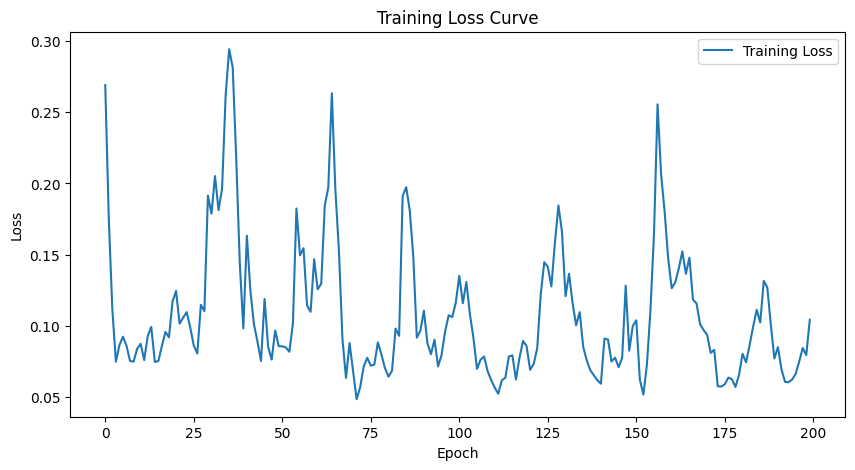

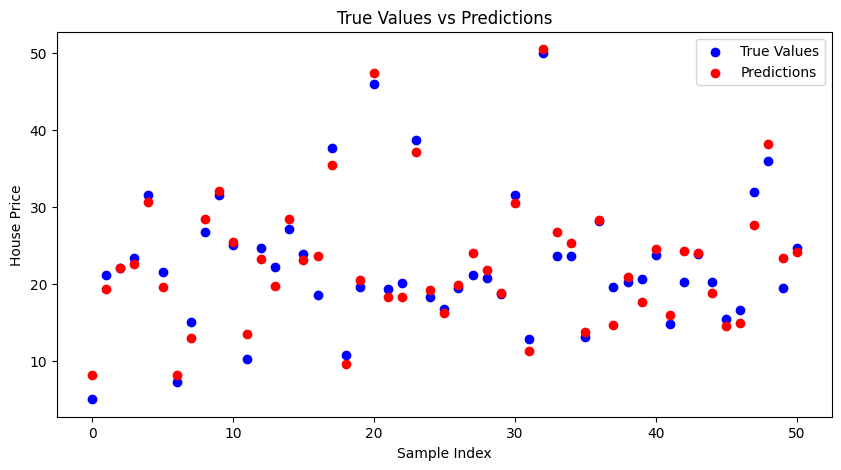

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

@torch.no_grad()
def test(test_xt):
    model = Model()
    model.load_state_dict(torch.load("./6.波士顿房价预测.pth"))
    model.eval()
    out = model(test_xt)
    return out
# 进行预测
predictions = test(test_xt).numpy().flatten()
true_values = test_yt.numpy()

# 绘制预测值和真实值的对比图
plt.figure(figsize=(10, 5))
plt.scatter(range(len(true_values)), true_values, label='True Values', color='blue')
plt.scatter(range(len(predictions)), predictions, label='Predictions', color='red')
plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()

In [75]:

predit = test(test_xt)
predit[50], test_yt[50]

(tensor([24.1907]), tensor(24.6000))

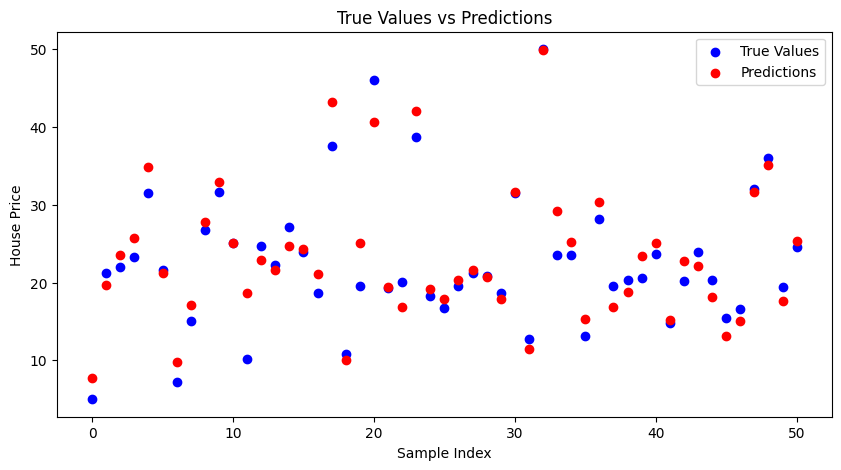

In [19]:
# 进行预测
predictions = test(test_xt).numpy().flatten()
true_values = test_yt.numpy()

# 绘制预测值和真实值的对比图
plt.figure(figsize=(10, 5))
plt.scatter(range(len(true_values)), true_values, label='True Values', color='blue')
plt.scatter(range(len(predictions)), predictions, label='Predictions', color='red')
plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()